# 1. Data exploration and cleaning
In this notebook we will begin with the initial exploration and cleaning of the datasets for the Publications track of Hércules challenge.

## Setup

In this section we are going to perform the initial setup of the notebook and define the constants and functions which will be shared for both datasets.

First of all, we are going to add the src directory to the sys path so we can import the modules defined inside that directory. Then, we are going to start the logging system:

In [1]:
import logging
import os
import sys

# set up module paths for imports
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
src_path = os.path.abspath(os.path.join('..', 'src'))
sys.path.append(src_path)

# start logging system and set logging level
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("Starting logger")

INFO:root:Starting logger


In the following cell we are going to define common constants and functions shared by both datasets of this track. The ResearchArticle class is also imported from the src package. This class serves as a common interface between the Agriculture and CORD19 datasets. More information about it can be seen at the *src/research_article.py* module.

In [47]:
from src import ResearchArticle

DATA_DIR = os.path.join(module_path, 'data')

def plot_df_hist(df, col, x_label, y_label, color='#9067a7'):
    ax = df.hist(column=col, bins=20, figsize=(12,8), color=color, zorder=2, rwidth=0.9, grid=False)
    ax = ax[0]
    for x in ax:
        x.set_title("")
        x.set_xlabel(x_label, labelpad=20, size=12)
        x.set_ylabel(y_label, labelpad=20, size=12)

def print_empty_cols(df):
    for col in df.columns:
        print(col)
        print('-' * len(col))
        res = df[df[col] == ''].index
        print(f"{len(res)} articles have no value for column {col}")
        print(res)
        print('\n')


## Dataset 1: COVID-19

We will begin with the CORD19 dataset. This dataset consists of a list of articles (130003 at the time of writing) included in the **COVID-19 Open Research Data Challenge** proposed by Kaggle.

The following cell will define constants for the name of the dataset, and the directory where it will be saved:

In [38]:
CORD_DATASET_NAME = "allen-institute-for-ai/CORD-19-research-challenge"
CORD_DATASET_DIR = os.path.join(DATA_DIR, 'cord19')

### Dowloading the dataset from kaggle

Since the dataset belongs to a Kaggle competition, we will need to authenticate ourselves before we can download it. It is necessary to have an account created with Kaggle in order to execute the following cells. Another alternative is to unzip the dataset inside the *data/cord19* folder, and skip to the next section (Parsing the data).

In the following cell, a prompt will appear to enter your Kaggle username and API key associated to your account. More information about how to obtain the API can be accessed at the [following link](https://www.kaggle.com/docs/api):

In [24]:
import getpass
import os

try:
    from secret import KAGGLE_USER, KAGGLE_KEY
except ModuleNotFoundError:
    KAGGLE_USER = input("Please enter your kaggle username: ")
    KAGGLE_KEY = getpass.getpass("Please enter your kaggle API key: ")

os.environ['KAGGLE_USERNAME'] = KAGGLE_USER
os.environ['KAGGLE_KEY'] = KAGGLE_KEY

Please enter your kaggle username: alejgh
Please enter your kaggle API key: ········


Now that we have entered the Kaggle credentials, we will proceed to download and unzip the dataset in our *data/cord19* folder. This operation may take a few minutes:

In [9]:
import kaggle


kaggle.api.dataset_download_files(CORD_DATASET_NAME, path=CORD_DATASET_DIR, unzip=True)

### Parsing the data

Now that the dataset has been downloaded and extracted, we can start parsing the data. We will begin by retrieving all the json files from the dataset:

In [4]:
import glob

json_filenames = glob.glob(f'{CORD_DATASET_DIR}/**/*.json', recursive=True)

And now we are going to import an auxiliary function defined in the src.cord19 package which parses a given json file from the dataset and builds a *ResearchArticle* instance:

In [6]:
from src.cord19 import parse_cord_file

parse_cord_file(json_filenames[0])

0001418189999fea7f7cbe3e82703d71c85a6fe5 - Absence of surface expression of feline infectious peritonitis virus (FIPV) antigens on infected cells isolated from cats with FIP - Feline inf... - Feline infectious pe...

We can iterate over all of the files to parse the complete dataset:

In [7]:
cord19_dataset = [parse_cord_file(file_name) for file_name in json_filenames]

### Creating the dataframe

After parsing the data we have obtained 130,003 instances of the *ResearchArticle* class. However, in order to work with the data it is more convenient to use DataFrames from the pandas library. We have already implemented a *to_dict* method in the *ResearchArticle* class that facilitates the creation of Dataframes:

In [22]:
import pandas as pd

cord19_df = pd.DataFrame.from_records([article.to_dict() for article in cord19_dataset])
cord19_df.head(n=7)

,id,title,abstract,full_body,authors,references,subjects
0,0001418189999fea7f7cbe3e82703d71c85a6fe5,Absence of surface expression of feline infect...,Feline infectious peritonitis virus (FIPV) pos...,Feline infectious peritonitis (FIP) is a fatal...,E Cornelissen|H L Dewerchin|E Van Hamme|H J N...,Using direct immunofluorescence to detect coro...,
1,00016663c74157a66b4d509d5c4edffd5391bbe0,,,Viruses are increasingly recognised as pathoge...,,Principles of Virology in Fields Virology|Inac...,
2,0003793cf9e709bc2b9d0c8111186f78fb73fc04,Title: Rethinking high-risk groups in COVID-19,,How do we protect our 'high-risk' patient popu...,Anastasia Vishnevetsky|Michael Levy,COVID-19)|Prevalence of comorbidities in the n...,
3,00039b94e6cb7609ecbddee1755314bcfeb77faa,Plasma inflammatory cytokines and chemokines i...,Severe acute respiratory syndrome (SARS) is a ...,Severe acute respiratory syndrome (SARS) is a ...,W K Lam|C K Wong|C W K Lam|A K L Wu|W K Ip|N L...,A major outbreak of severe acute respiratory s...,
4,0003ddc51c4291d742855e9ac56076a3bea33ad7,Journal Pre-proofs The Fire This Time: The Str...,,It is said that crisis reveals character. The ...,Olusola Ajilore|April D Thames,Ethnic Disparities in Hospitalisation for COVI...,
5,0004456994f6c1d5db7327990386d33c01cff32a,,Background: Influenza immunisation for healthc...,The German standing commission for immunisatio...,Chris J Williams|Brunhilde Schweiger|Genia D...,STIKO: Mitteilung der Ständigen Impfkommission...,
6,0004774b55eb0dad880aba9b572efe362660c5e0,Disaster Perceptions,,". So, if there is no singular definition of ri...",,Principles of emergency planning and managemen...,


In [39]:
cord19_df.iloc[82]

id                         0043d044273b8eb1585d3a66061e9b4e03edc062
title             Evaluation of the tuberculosis programme in Ni...
abstract          Background: Tuberculosis is a devastating dise...
full_body         The Ministry of Health of the People's Republi...
authors           Yu Rong Yang|Donald P Mcmanus|Darren J Gray|Xi...
references        Analysis of factors affecting the epidemiology...
subjects                                                           
text_cleaned      The Ministry of Health of the People's Republi...
num_chars_text                                                19663
Name: 82, dtype: object

### Cleaning and feature engineering

In this section we are going to clean the dataset and add additional features to the data that could be useful in later phases.

Since the body text of each article is already in a good format, we will just remove extra spaces from it:

In [40]:
import re

cord19_df['text_cleaned'] = cord19_df['full_body'].apply(lambda x: re.sub(' +', ' ', x).strip())
cord19_df['text_cleaned'].loc[0][:500]

'Feline infectious peritonitis (FIP) is a fatal chronic disease in cats caused by a coronavirus, feline infectious peritonitis virus (FIPV), and characterized by granulomatous lesions formed at the serosae of different organs. Two forms can be distinguished. Cats suffering from the wet or effusive form have exudates in their body cavities. Exudate is absent in the second form, hence the name dry or non-effusive form.\n FIPV-infected cells are detected in the pyogranulomas and, based on morphology '

We will also add a new column to the Dataframe with the number of characters of each article. This column will be usfeul to detect some anomalies and evaluate which models will perform better of worse with the given text size:

In [41]:
cord19_df['num_chars_text'] = cord19_df['text_cleaned'].apply(lambda x: len(x))

We can also make use of the function defined in the setup section to check how many cells have no value (empty string):

In [48]:
print_empty_cols(cord19_df)

id
--
0 articles have no value for column id
Int64Index([], dtype='int64')


title
-----
8084 articles have no value for column title
Int64Index([    1,     5,     7,    21,    22,    35,    47,    54,    98,
              154,
            ...
            75234, 75241, 75260, 75264, 75269, 75270, 75280, 75283, 75287,
            75297],
           dtype='int64', length=8084)


abstract
--------
78252 articles have no value for column abstract
Int64Index([     1,      2,      4,      6,      7,      9,     13,     14,
                15,     18,
            ...
            129993, 129994, 129995, 129996, 129997, 129998, 129999, 130000,
            130001, 130002],
           dtype='int64', length=78252)


full_body
---------
0 articles have no value for column full_body
Int64Index([], dtype='int64')


authors
-------
7722 articles have no value for column authors
Int64Index([     1,      6,     18,     21,     22,     35,     43,     47,
                54,     86,
            ...
     

From the data above we can see that more than half of the articles (78252) do not have a value for the abstract, and some of them (7722) do not have a value for its authors.

Even more importantly, although all the full_body cells are not empty, some of the text_cleaned (21) are. We are going to explore this to see what may be the cause of the issue:

In [62]:
cord19_df.iloc[100983].full_body

'\n\n\n \n\n\n \n\n\n \n\n\n \n\n\n \n\n\n \n\n\n \n\n'

It seems that although all of the articles have a value for the text body, for some of them it consists mainly of newlines and spaces, which are removed when producing the *text_cleaned* column. We can remove these articles from the Dataframe, since

### Initial exploration

In [42]:
cord19_df['abstract'].describe(include='all')

count     130003
unique     50264
top             
freq       78252
Name: abstract, dtype: object

In [56]:
cord19_df.iloc[1000].num_chars_text

23572

In [55]:
cord19_df['num_chars_text'].describe()

count    1.300030e+05
mean     2.666194e+04
std      5.234091e+04
min      0.000000e+00
25%      1.067900e+04
50%      2.010700e+04
75%      3.125900e+04
max      4.111331e+06
Name: num_chars_text, dtype: float64

TODO: investigate more with the MAX article (how many articles have more than 1e+06 chars?)

We can delete them if they are not too many (10 or so from 130003)

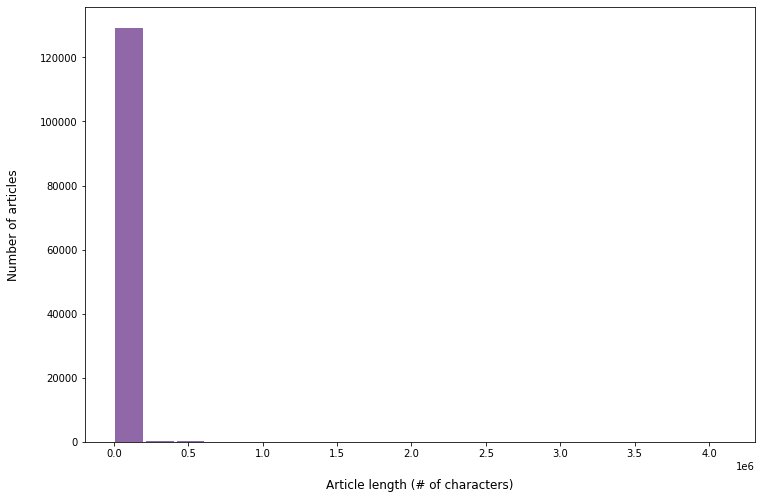

In [43]:
plot_df_hist(cord19_df, 'num_chars_text', 'Article length (# of characters)', 'Number of articles')

### Serializing the dataframe

In [57]:
CORD19_FILE_PATH = os.path.join(CORD_DATASET_DIR, 'cord19_dataframe.pkl')

cord19_df.to_pickle(CORD19_FILE_PATH)

## Dataset 2: Agriculture

### Getting the article IDs to retrieve

In [12]:
AGRICULTURE_DATASET_DIR = os.path.join(DATA_DIR, 'agriculture')
article_ids_file = os.path.join(AGRICULTURE_DATASET_DIR, 'pmc_ids.txt')

def load_ids(base_file):
    with open(base_file , 'r') as f:
        ids = f.read().splitlines()
    return ids


In [13]:
article_ids = load_ids(article_ids_file)
len(article_ids)

127

In [14]:
article_ids[0]

'PMC3310815'

### Loading the XML data from the EuropeBMC API

In [15]:
BMC_BASE_API = 'https://www.ebi.ac.uk/europepmc/webservices/rest'

In [16]:
import requests

def load_pmc_data(ids_to_download):
    return {pmc_id: requests.get(f"{BMC_BASE_API}/{pmc_id}/fullTextXML").content 
            for pmc_id in ids_to_download}

pmc_dataset_xml = load_pmc_data(article_ids)

Since one of the articles is not available for reuse ('PMC6472519') we are going to remove it from the whole track in order to comply with its license. More information about this issue can be found at https://github.com/weso-edma/hercules-challenge-publications/issues/3.

In [17]:
del pmc_dataset_xml['PMC6472519']

### Parsing the data

In [19]:
from src.agriculture import parse_pmc_article

pmc_articles = [parse_pmc_article(article_xml) for article_xml in pmc_dataset_xml.values()]
pmc_articles[0]

3310815 - Induced Release of a Plant-Defense Volatile ‘Deceptively’ Attracts Insect Vectors to Plants Infected with a Bacterial Pathogen - Transmissi... - Introduction Transmi...

### Creating the dataframe

In [20]:
import pandas as pd

pmc_df = pd.DataFrame.from_records([article.to_dict() for article in pmc_articles])
pmc_df.head(n=7)

/home/alejandro/.envs/edma/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


,id,title,abstract,full_body,authors,references,subjects
0,3310815,Induced Release of a Plant-Defense Volatile ‘D...,Transmission of plant pathogens by insect vect...,Introduction Transmission of plant pathogens b...,Mann Rajinder S.|Ali Jared G.|Hermann Sara L.|...,Insect vector relationships with procaryotic p...,Agriculture|Crops|Pest Control|Biology|Ecology...
1,3547067,Carbon and Nitrogen Isotopic Survey of Norther...,The development of isotopic baselines for comp...,Introduction Stable isotope analysis is an imp...,Szpak Paul|White Christine D.|Longstaffe Fred ...,Influence of diet on the distribution of carbo...,Biology|Ecology|Biogeochemistry|Paleontology|P...
2,3668195,The effect of ‘Candidatus Liberibacter asiatic...,BackgroundHuanglongbing (HLB) is a highly dest...,Background Citrus Huanglongbing (HLB) or citru...,Nwugo Chika C|Lin Hong|Duan Yongping|Civerolo ...,"Huanglongbing: a destructive, newly-emerging, ...",
3,3672096,Emissions of CH4 and N2O under Different Tilla...,Understanding greenhouse gases (GHG) emissions...,Introduction With the current rise in global t...,Zhang Hai-Lin|Bai Xiao-Lin|Xue Jian-Fu|Chen Zh...,Simulation of fluxes of greenhouse gases from ...,Agriculture|Agricultural Biotechnology|Agricul...
4,3676804,"Physiological, Biochemical, and Molecular Mech...",High temperature (HT) stress is a major enviro...,1. Introduction Among the ever-changing compon...,Hasanuzzaman Mirza|Nahar Kamrun|Alam Md. Mahab...,Climate change 2007–The physical science basis...,
5,3676838,Plant Defense against Insect Herbivores,Plants have been interacting with insects for ...,1. Introduction Land plants and insects have c...,Fürstenberg-Hägg Joel|Zagrobelny Mika|Bak Søren,Butterflies and plants: A study in coevolution...,
6,3818224,Enhanced Methanol Production in Plants Provide...,Plants naturally emit methanol as volatile org...,Introduction Insect pests cause approximately ...,Dixit Sameer|Upadhyay Santosh Kumar|Singh Harp...,Pesticides and pest control|Biotechnology as a...,


In [43]:
pmc_df.iloc[82]

id                                                      6213855
title         Importance of Mineral Nutrition for Mitigating...
abstract      Aluminum (Al) toxicity is one of the major lim...
full_body     1. Introduction Aluminum (Al) toxicity represe...
authors       Rahman Md. Atikur|Lee Sang-Hoon|Ji Hee Chung|K...
references    Plant adaptation to aid soils: The molecular b...
subjects                                                       
Name: 82, dtype: object

In [134]:
pmc_df.iloc[0].full_body[:300]

'Introduction Transmission of plant pathogens by insect vectors is a complex biological process involving interactions between the plant, insect, and pathogen  [1] – [2] . Pathogens can induce changes in the traits of their primary hosts as well as their vectors to affect the frequency and nature of '

### Cleaning and feature engineering

In [96]:
def clean(text):
    text = text.replace(u'\u200a', ' ')
    return re.sub(' +', ' ', text).strip()


In [97]:
pmc_df['text_cleaned'] = pmc_df['full_body'].apply(lambda x: clean(x))
pmc_df['text_cleaned'].loc[0][:500]

'Introduction Transmission of plant pathogens by insect vectors is a complex biological process involving interactions between the plant, insect, and pathogen [1] – [2] . Pathogens can induce changes in the traits of their primary hosts as well as their vectors to affect the frequency and nature of interactions between hosts and vectors [3] – [13] . Plant morphology, as well as, primary and secondary plant compounds, including emitted volatiles and plant nutrients, are some of the traits that can'

In [130]:
pmc_df['num_chars_text'] = pmc_df['text_cleaned'].apply(lambda x: len(x))

### Initial exploration of the data

We will begin by checking if there are any empty or null values in our dataset:

In [49]:
pmc_df.isnull().sum()

id            0
title         0
abstract      0
full_body     0
authors       0
references    0
subjects      0
dtype: int64

Although there is no null value in the dataset, some of the strings could be empty still. We are going to quickly check this by iterating over all of the columns from the df:

In [70]:
print_empty_cols(pmc_df)

id
--
Int64Index([], dtype='int64')


title
-----
Int64Index([], dtype='int64')


abstract
--------
Int64Index([], dtype='int64')


full_body
---------
Int64Index([], dtype='int64')


authors
-------
Int64Index([], dtype='int64')


references
----------
Int64Index([], dtype='int64')


subjects
--------
Int64Index([  2,   4,   5,   6,  15,  18,  19,  21,  22,  23,  24,  28,  30,
             32,  33,  35,  36,  37,  42,  43,  52,  53,  55,  56,  57,  58,
             59,  61,  62,  63,  64,  66,  69,  70,  72,  74,  81,  82,  91,
             93,  95,  97,  98,  99, 103, 104, 105, 106, 107, 108, 111, 112,
            113, 115, 117, 118, 119, 120, 121, 123, 125],
           dtype='int64')




We can see above that some of the articles have an empty value for its subjects. However, every other cells contains some information.

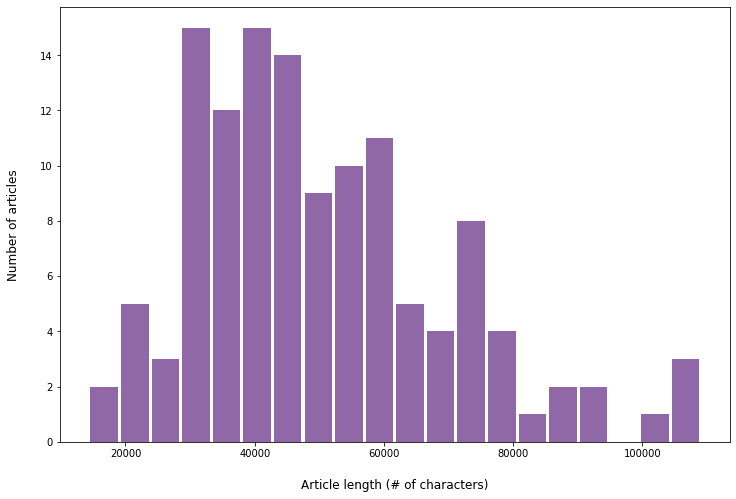

In [136]:
plot_df_hist(pmc_df, 'num_chars_text', 'Article length (# of characters)', 'Number of articles')

In [ ]:
pmc_df['num_chars_text'].describe()

TODO: save figures to results folder

### Serializing the dataframe

In [21]:
PMC_FILE_PATH = os.path.join(AGRICULTURE_DATASET_DIR, 'pmc_dataframe.pkl')

pmc_df.to_pickle(PMC_FILE_PATH)